In [1]:
from pybaseball import schedule_and_record
from pybaseball import teamid_lookup
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
team_dict = {'NL West':['LAD','SFG','SDP','ARI','COL'],
             'NL Central':['CHC','CIN','STL','MIL','PIT'],
             'NL East':['NYM','PHI','MIA','ATL','WSN'],
             'AL West':['SEA','OAK','HOU','LAA','TEX'],
             'AL Central':['CHW','CLE','DET','MIN','KCR'],
             'AL East':['BOS','TBR','NYY','TOR','BAL']}

capacity_dict = {'LAD':56000,'SFG':41265,'SDP':40209,'ARI':48686,'COL':50144
                 ,'CHC':41649,'CIN':42319,'STL':45494,'MIL':41900,'PIT':38747
                 ,'NYM':41922,'PHI':42792,'MIA':37442,'ATL':41084,'WSN':41339
                 ,'SEA':47929,'OAK':46765,'HOU':41168,'LAA':45517,'TEX':40300
                 ,'CHW':40615,'CLE':35041,'DET':41083,'MIN':38544,'KCR':37903
                 ,'BOS':37755,'TBR':42735,'NYY':52325,'TOR':16600,'BAL':45971}

color_dict = {'LAD':'#002f6c','SFG':'#fa4616','SDP':'#2F241D','ARI':'#a71930','COL':'#33006F'
              ,'CHC':'#002f6c','CIN':'#d50032','STL':'#ba0c2f','MIL':'#13294b','PIT':'#ffc72c'
              ,'NYM':'#fc4c02','PHI':'#ba0c2f','MIA':'#00a3e0','ATL':'#002855','WSN':'#ba122b'
              ,'SEA':'#00685e','OAK':'#003831','HOU':'#002d62','LAA':'#ba0021','TEX':'#003278'
              ,'CHW':'#27251f','CLE':'#0f223e','DET':'#0c2340','MIN':'#0c2341','KCR':'#004687'
              ,'BOS':'#c8102e','TBR':'#8fbce6','NYY':'#162546','TOR':'#134a8e','BAL':'#fc4c02'}

walk_score = {'LAD':22,'SFG':86,'SDP':85,'ARI':63,'COL':88
              ,'CHC':92,'CIN':74,'STL':73,'MIL':15,'PIT':77
              ,'NYM':50,'PHI':38,'MIA':77,'ATL':35,'WSN':86
              ,'SEA':60,'OAK':22,'HOU':71,'LAA':39,'TEX':29
              ,'CHW':67,'CLE':87,'DET':83,'MIN':87,'KCR':22
              ,'BOS':96,'TBR':53,'NYY':93,'TOR':95,'BAL':81}

In [3]:
totaldf = pd.DataFrame()
totaldf['Division'] = ''
for key in team_dict:
    for team in team_dict[key]:
        totaldf = totaldf.append(schedule_and_record(2021,team))
        totaldf.loc[totaldf['Tm'] == team,'Division'] = key

totaldf = totaldf[-totaldf['Time'].isna()]
totaldf['Wins'] = [int(x.split('-')[0]) for x in totaldf['W-L']]
totaldf['Losses'] = [int(x.split('-')[1]) for x in totaldf['W-L']]
totaldf['Win_Perc'] = totaldf['Wins'] / (totaldf['Losses'] + totaldf['Wins'])
totaldf['Game_Number'] = totaldf['Wins'] + totaldf['Losses']
totaldf['Win_Perc_Over'] = totaldf['Win_Perc']-0.5
totaldf['Capacity'] = totaldf['Tm'].apply(lambda x: capacity_dict.get(x))
totaldf['Capacity_Perc'] = (totaldf['Attendance']) / totaldf['Capacity']
totaldf['Color'] = totaldf['Tm'].apply(lambda x: color_dict.get(x))
totaldf['Walk_Score'] = totaldf['Tm'].apply(lambda x: walk_score.get(x))

In [4]:
homedf = totaldf[totaldf['Home_Away'] =='Home']

In [5]:
cap_scatter = homedf.groupby(['Tm']).agg({'Capacity_Perc':'mean'
                                          ,'Capacity':'mean'
                                          ,'Walk_Score':'max'})#['max','min','mean','median']})
cap_scatter['Wins']=(totaldf.groupby(['Tm']).agg({'Wins':'max'}))
cap_scatter = cap_scatter.reset_index()
cap_scatter['Capacity_Perc'] = cap_scatter['Capacity_Perc'] * 100

quadrants = ['Bad Team\nGood Attendance','Bad Team\nBad Attendance'
             ,'Good Team\nBad Attendance','Good Team\nGood Attendance']

x= list(cap_scatter['Capacity_Perc'])
y= list(cap_scatter['Wins'])
labels = list(cap_scatter['Tm'])

In [6]:
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.08)

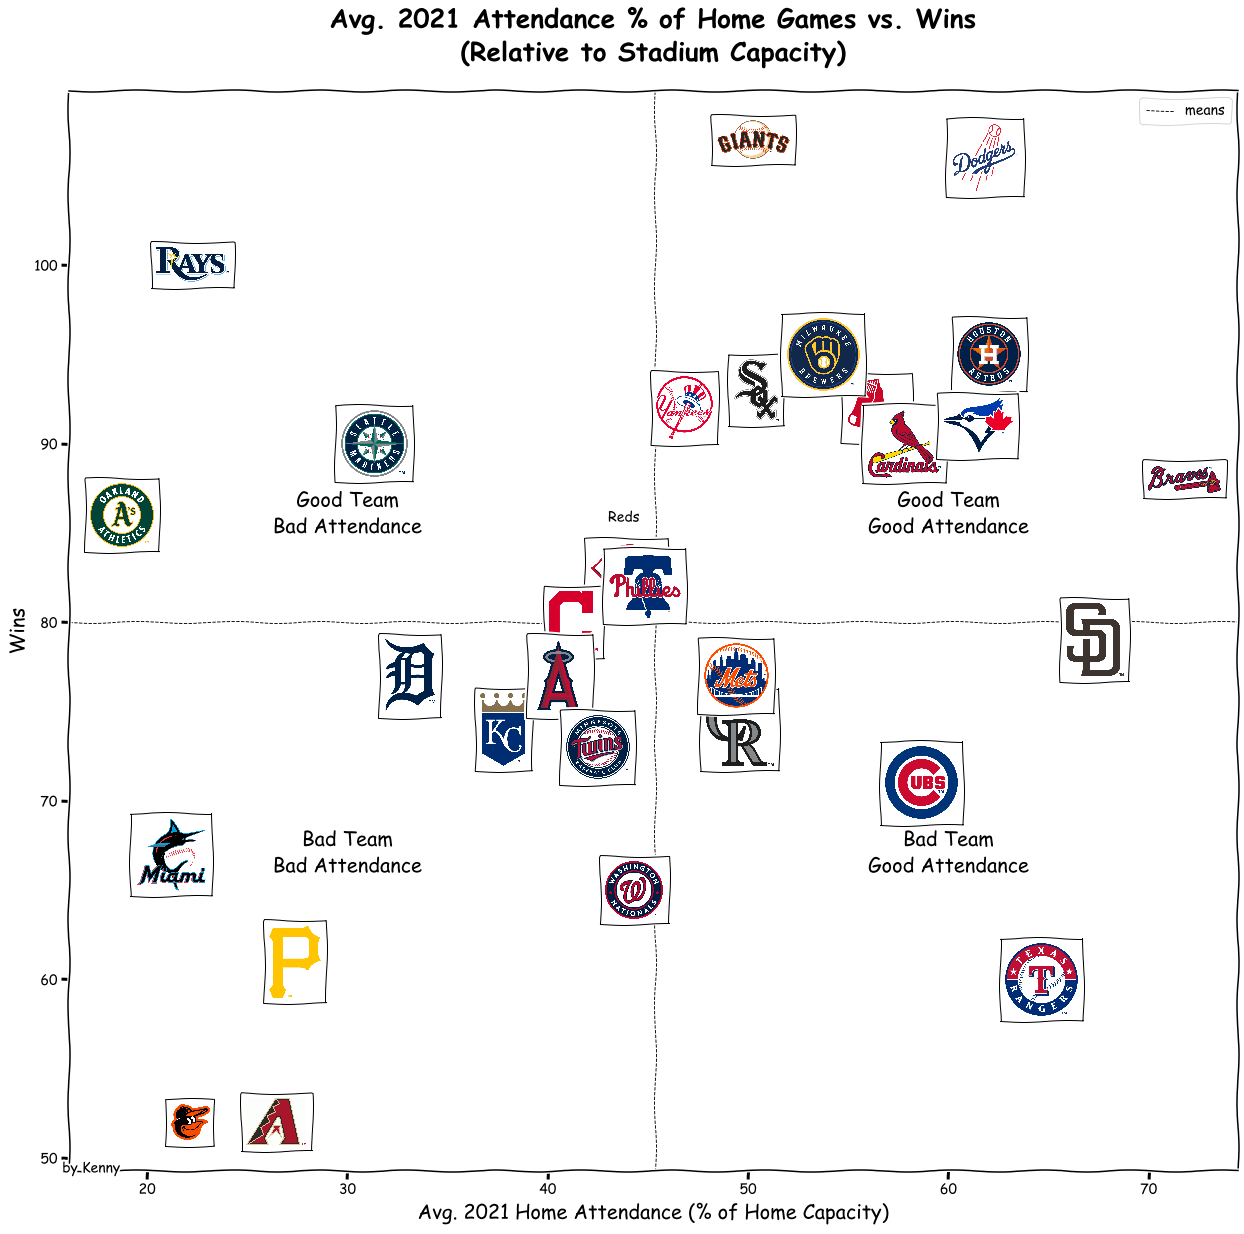

In [13]:
conf = dict(
    label_size=20,
    title_size=26,
    quad_text_size = 50,
    quad_text_alpha = .05
)

fig, ax = plt.subplots(figsize=(18, 18))
plt.xkcd()
sns.scatterplot(x='Capacity_Perc',y='Wins',data=cap_scatter)
    
imgs = [
    ax.add_artist(
        AnnotationBbox(getImage(f'{team.Tm}.png'),
                      (team.Capacity_Perc, team.Wins),
                       frameon=True
                      )
    )
    for team in cap_scatter.itertuples()
]
ax.axhline(int(cap_scatter.agg({'Wins':'mean'})), ls='--', c='k', lw=0.9, label="means")
ax.axvline(float(cap_scatter.agg({'Capacity_Perc':'mean'})), ls='--', c='k', lw=0.9)

ax.annotate(quadrants[0],(60,66),ha='center',fontsize=20)
ax.annotate(quadrants[1],(30,66),ha='center',fontsize=20)
ax.annotate(quadrants[2],(30,85),ha='center',fontsize=20)
ax.annotate(quadrants[3],(60,85),ha='center',fontsize=20)

#annotate cleveland
ax.annotate("Reds"
    ,(47,89)
    ,xytext = (-80,-60)
    ,textcoords="offset pixels"
)
plt.legend()
plt.title('Avg. 2021 Attendance % of Home Games vs. Wins\n(Relative to Stadium Capacity)'
          ,size = conf["title_size"]
          ,pad = 30
          ,fontweight = 'bold')
plt.xlabel('Avg. 2021 Home Attendance (% of Home Capacity)'
           ,size = conf['label_size'])
plt.ylabel('Wins'
           ,size = conf['label_size'])
plt.annotate("by Kenny", (.05,.05), xycoords='figure fraction')
plt.tight_layout()
plt.savefig('attendance_vs_wins_Final.png')
#plt.show()